<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN を用いた CIFAR-10 dataset の分類
(2025.06.18メモ) GPU を利用できるよう，コードを微修正した。

### CIFAR-10 dataset の可視化

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


各クラスから1枚ずつの画像表示:


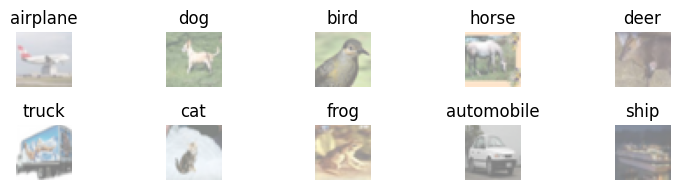


CIFAR-10データセット情報:
訓練データ数: 50000
クラス数: 10
画像サイズ: torch.Size([3, 32, 32])
クラス名: ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10のクラス名
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# データ変換の定義（正規化なしで可視化用）
transform = transforms.Compose([
    transforms.ToTensor()
])

# CIFAR-10データセットの読み込み
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# データローダーの作成
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,
                                         shuffle=True, num_workers=2)

def imshow(img, title=None):
    """テンソル画像を表示する関数"""
    img = img / 2 + 0.5  # 非正規化（不要だが念のため）
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# 各クラスから1枚ずつ表示する別バージョン
print("各クラスから1枚ずつの画像表示:")

# 各クラスの画像を1枚ずつ集める
class_samples = {}
sample_count = 0

for images, labels in trainloader:
    for i, label in enumerate(labels):
        class_name = classes[label.item()]
        if class_name not in class_samples:
            class_samples[class_name] = images[i]
            sample_count += 1
            if sample_count == 10:  # 全クラス揃ったら終了
                break
    if sample_count == 10:
        break

# 各クラス1枚ずつを2x5のグリッドで表示
plt.figure(figsize=(8, 2))
for i, (class_name, img) in enumerate(class_samples.items()):
    plt.subplot(2, 5, i + 1)
    imshow(img, class_name)

plt.tight_layout()
# plt.suptitle('CIFAR-10 Dataset - One Sample per Class', fontsize=16, y=1.02)
plt.show()

# データセット情報の出力
print(f"\nCIFAR-10データセット情報:")
print(f"訓練データ数: {len(trainset)}")
print(f"クラス数: {len(classes)}")
print(f"画像サイズ: {images[0].shape}")
print(f"クラス名: {classes}")

### ライブラリのインポート

In [2]:
# 必要なライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# GPU 利用の可否をチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


### データローダーの生成

In [3]:
# CIFAR-10データの準備
def prepare_cifar10_data():
    # CIFAR-10のクラス名
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # データ変換（前処理）
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 水平反転でデータ拡張
        transforms.RandomRotation(10),           # 回転でデータ拡張
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 色調変更
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # データセット読み込み
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    # データローダー
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )

    print(f"訓練データ数: {len(trainset)}")
    print(f"テストデータ数: {len(testset)}")

    return trainloader, testloader, classes

# データローダーの生成
trainloader, testloader, classes = prepare_cifar10_data()

100%|██████████| 170M/170M [00:06<00:00, 26.1MB/s]


訓練データ数: 50000
テストデータ数: 10000


### モデルの定義

In [5]:
# CNN モデルの定義
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()

        # 特徴抽出部
        self.features = nn.Sequential(
            # 第1ブロック: 32×32×3 → 16×16×32
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 畳み込み
            nn.BatchNorm2d(32),  # バッチ正規化
            nn.ReLU(inplace=True), # 活性化関数
            nn.MaxPool2d(kernel_size=2, stride=2), # プーリング

            # 第2ブロック: 16×16×32 → 8×8×64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 第3ブロック: 8×8×64 → 4×4×128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 分類部
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),     # ドロップアウト
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        # x = x.view(x.size(0), -1)  # 平坦化
        x = x.reshape((x.size(0), -1))  # 平坦化
        x = self.classifier(x)
        return x

### モデルの学習

In [6]:
# モデルのインスタンス化
model = CIFAR10_CNN().to(device)
print(model)

# (参考) パラメータ数確認
total_params = sum(p.numel() for p in model.parameters())
print(f"\n(参考)モデルに含まれる総パラメータ数: {total_params:,}")

# 損失関数 ＆ 最適化アルゴリズム
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 学習ループ
def train_cifar10_cnn(num_epochs=5):
    print(f"\n=== 学習開始 ===")

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\nエポック {epoch+1}/{num_epochs}")
        print("------------------------------")

        for i, (inputs, labels) in enumerate(trainloader):
            # 必要に応じてデータを GPU へ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 100 == 0:
                print(f"バッチ [{i+1}/{len(trainloader)}], 損失: {loss.item():.4f}, 正解率: {100*correct/total:.2f}%")

        # エポック終了時の統計
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = correct / total * 100

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"エポック {epoch+1} : 平均損失: {epoch_loss:.4f} 正解率: {epoch_acc:.2f}%")

    return train_losses, train_accuracies

# モデルの学習
train_losses, train_accuracies = train_cifar10_cnn(num_epochs=5)

CIFAR10_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=512, bias=Tr

### テストデータを与えて，モデルを評価

In [7]:
# テスト評価
def evaluate_cifar10_cnn():
    print(f"\n=== テスト開始 ===")

    model.eval() # 評価モードに設定
    correct = 0 # 正解数を記録
    total = 0
    class_correct = list(0.0 for i in range(10)) # [0.0, 0.0, ..., 0.0] のリストを作る
    class_total = list(0.0 for i in range(10))

    with torch.no_grad(): # モデルの重みを更新しない
        for inputs, labels in testloader:
            # 必要に応じてデータを GPU へ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # クラス別の精度を計算
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    overall_accuracy = 100 * correct / total
    print(f"全体テスト精度: {overall_accuracy:.2f}%")

    print('\nクラス別精度:')
    for i in range(10):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f'{classes[i]}: {accuracy:.2f}%')

    return overall_accuracy

final_accuracy = evaluate_cifar10_cnn()


=== テスト開始 ===
全体テスト精度: 72.88%

クラス別精度:
airplane: 75.60%
automobile: 82.60%
bird: 54.60%
cat: 63.30%
deer: 69.10%
dog: 60.70%
frog: 83.10%
horse: 72.50%
ship: 84.00%
truck: 83.30%


### 学習曲線の可視化

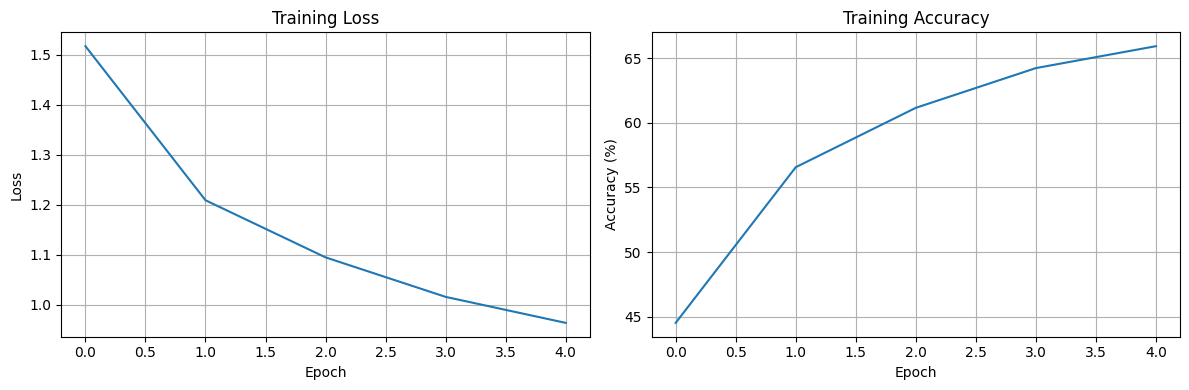

In [8]:
# 学習曲線の可視化
def plot_training_curves():
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves()